In [1]:
# !pip uninstall -y protobuf
# !pip install protobuf==3.20.3


In [15]:
import os
import random
import numpy as np
import soundfile as sf
import torch
import pandas as pd

from tqdm import tqdm
from transformers import AutoFeatureExtractor, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

## Вспомогательные функции

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def show_confusion_matrix(y_true, y_pred, classes, title="Матрица ошибок"):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    
    sns.heatmap(
        cm, 
        annot=True,        
        fmt='d',          
        xticklabels=classes, 
        yticklabels=classes, 
        cmap='Blues'        
    )
    
    plt.ylabel('На самом деле (True)')
    plt.xlabel('Предсказано (Predicted)')
    plt.title(title)
    plt.show()

In [4]:
def show_simple_report(y_true, y_pred, target_names):
    report_dict = classification_report(
        y_true, 
        y_pred, 
        target_names=target_names, 
        output_dict=True
    )
    
    df_report = pd.DataFrame(report_dict).transpose()
    
    return df_report.style.format({
        'precision': '{:.3f}',  
        'recall':    '{:.3f}',
        'f1-score':  '{:.3f}',
        'support':   '{:.0f}'  
    })

In [5]:
DATA_DIR = "/kaggle/input/voxlingua107"

LANGS = ["ru", "en", "es", "fr", "de"]

label_map = {
    "ru": 0,
    "en": 1,
    "es": 2,
    "fr": 3,
    "de": 4,
}

FILES_PER_LANG = 5000

TARGET_SR = 16000
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

## Загружаем модель

In [6]:
MODEL_NAME = "ntu-spml/distilhubert"

feature_extractor = AutoFeatureExtractor.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

model.eval()
model.to(DEVICE)


preprocessor_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

2025-12-25 13:35:34.718219: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766669734.933305      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766669734.992138      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766669735.469337      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766669735.469378      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766669735.469382      55 computation_placer.cc:177] computation placer alr

model.safetensors:   0%|          | 0.00/94.0M [00:00<?, ?B/s]

HubertModel(
  (feature_extractor): HubertFeatureEncoder(
    (conv_layers): ModuleList(
      (0): HubertGroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x HubertNoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x HubertNoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): HubertFeatureProjection(
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): HubertEncoder(
    (pos_conv_embed): HubertPositionalConvEmbedding(
      (conv): ParametrizedConv1d(
        768, 768, kernel_size=(128,), stride=(1,), paddi

In [7]:
def load_audio(path, target_sr=16000):
    y, sr = sf.read(path)

    if y.ndim > 1:
        y = y.mean(axis=1)

    if sr != target_sr:
        import librosa
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)

    return y


## Достаем фичи с помощью энкодера

In [8]:
@torch.no_grad()
def extract_features(path):
    y = load_audio(path)

    inputs = feature_extractor(
        y,
        sampling_rate=16000,
        return_tensors="pt",
        padding=True
    )

    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

    outputs = model(**inputs, output_hidden_states=True)

    # берём средний слой, он лучше для LID
    hidden_states = outputs.hidden_states
    layer = hidden_states[len(hidden_states) // 2]  


    feats = layer.squeeze(0).cpu().numpy()  

    mean = feats.mean(axis=0)
    return mean
    # std = feats.std(axis=0)

    # return np.hstack([mean, std])


In [9]:
X = []
y = []

for lang in LANGS:
    lang_dir = os.path.join(DATA_DIR, f"{lang}/{lang}")

    files = [
        f for f in os.listdir(lang_dir)
        if f.endswith(".wav")
    ]

    random.shuffle(files)
    files = files[:FILES_PER_LANG]

    print(f"{lang}: используем {len(files)} файлов")

    for fname in tqdm(files):
        path = os.path.join(lang_dir, fname)

        try:
            feats = extract_features(path)
            X.append(feats)
            y.append(label_map[lang])
        except Exception as e:
            print(f"Ошибка в {path}: {e}")


ru: используем 5000 файлов


100%|██████████| 5000/5000 [03:33<00:00, 23.47it/s]


en: используем 5000 файлов


100%|██████████| 5000/5000 [03:27<00:00, 24.06it/s]


es: используем 5000 файлов


100%|██████████| 5000/5000 [03:31<00:00, 23.62it/s]


fr: используем 5000 файлов


100%|██████████| 5000/5000 [03:19<00:00, 25.07it/s]


de: используем 5000 файлов


100%|██████████| 5000/5000 [03:33<00:00, 23.45it/s]


In [10]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [11]:
print(X_train[0].shape[0], "признаков")

768 признаков


## Обучаем модель LogisticRegression

In [12]:
from sklearn.linear_model import LogisticRegression


clf = LogisticRegression(
    max_iter=5000,
    n_jobs=-1
)

clf.fit(X_train, y_train)


LogisticRegression(max_iter=5000, n_jobs=-1)

In [16]:
y_train_pred = clf.predict(X_train)

print("TRAIN")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
df_result_train = show_simple_report(y_train, y_train_pred, LANGS)

df_result_train


TRAIN
Accuracy: 0.9744


,precision,recall,f1-score,support
ru,0.975,0.973,0.974,4000
en,0.982,0.979,0.980,4000
es,0.967,0.974,0.971,4000
fr,0.969,0.972,0.970,4000
de,0.979,0.975,0.977,4000
accuracy,0.974,0.974,0.974,1
macro avg,0.974,0.974,0.974,20000
weighted avg,0.974,0.974,0.974,20000


In [17]:
# val
y_val_pred = clf.predict(X_val)

print("\nVALIDATION")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
df_result_val = show_simple_report(y_val, y_val_pred, LANGS)
df_result_val


VALIDATION
Accuracy: 0.964


,precision,recall,f1-score,support
ru,0.969,0.960,0.964,1000
en,0.975,0.974,0.974,1000
es,0.960,0.961,0.961,1000
fr,0.953,0.961,0.957,1000
de,0.963,0.964,0.964,1000
accuracy,0.964,0.964,0.964,1
macro avg,0.964,0.964,0.964,5000
weighted avg,0.964,0.964,0.964,5000


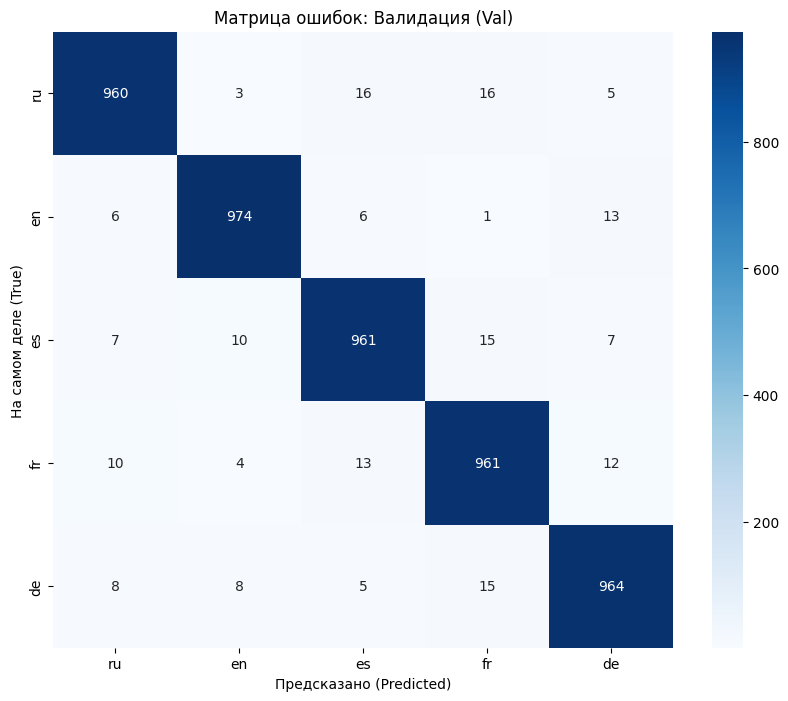

In [18]:
show_confusion_matrix(
    y_val, 
    y_val_pred, 
    classes=LANGS, 
    title="Матрица ошибок: Валидация (Val)"
)

## Сохраняем модель

In [19]:
from joblib import dump

dump(clf, "hubert_emb_clf.joblib")

['hubert_emb_clf.joblib']